# SOMperf Tests 

We test the results against predefined maps, and compare SOMperf metrics with manual computations or expected behaviors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

from somperf.metrics import *
from somperf.utils import *

In [2]:
ok = Image(filename='rc/check.png')
nok = Image(filename='rc/x.png')

def test_equal(somperf_value, expected_value):
    display(ok) if np.round(somperf_value, 9) == np.round(expected_value, 9) else display(nok)

def test_all_equal(somperf_values, expected_values):
    display(ok) if (np.round(somperf_values, 9) == np.round(expected_values, 9)).all() else display(nok)

def test_decreasing(somperf_values):
    display(ok) if (np.diff(somperf_values) <= 0.0).all() else display(nok)

def test_increasing(somperf_values):
    display(ok) if (np.diff(somperf_values) >= 0.0).all() else display(nok)

## Internal indices

To check the consistency of internal SOM quality indices, we perform tests on 2-dimensional fixed or random data and a hand-crafted map where prototypes were fixed manually. This way, we can compute the result manually and/or check if the indices have the right behavior in terms of topological organization.

In [3]:
small_map_size = (5, 5)
mid_map_size = (9, 9)
large_map_size = (17, 17)
xlarge_map_size = (33, 33)
all_map_sizes = [small_map_size, mid_map_size, large_map_size, xlarge_map_size]
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]

data_size = 420
low = -1.0
high = 1.0

random_seed = 42

In [4]:
def make_random(size, low=low, high=high, seed=random_seed):
    np.random.seed(seed)
    return np.random.uniform(low, high, size=(size, 2))

def make_grid(xsize, ysize, low=low, high=high):
    return np.dstack(np.meshgrid(np.linspace(low, high, xsize), np.linspace(low, high, ysize))).reshape(-1, 2)

### Quantization error

**1. Check that qe = 0 when samples and prototypes are identical for every map_size**

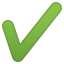

In [5]:
expected_value = 0
somperf_values = np.zeros(len(all_map_sizes))
for i, map_size in enumerate(all_map_sizes):
    X = make_grid(*map_size)
    prototypes = make_grid(*map_size)
    somperf_values[i] = quantization_error(som=prototypes, x=X)

test_all_equal(somperf_values, expected_value)

**2. Check that a random permutation of map units (i.e. removing topology) does not change qe**

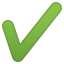

In [6]:
X = make_random(data_size)
prototypes = make_grid(*map_size)
expected_value = quantization_error(som=prototypes, x=X)
somperf_value = quantization_error(som=np.random.permutation(prototypes), x=X)

test_equal(somperf_value, expected_value)

**3. Check qe against a manually computed value**

For every map size, we add a random perturbation to grid points with a fixed radius equal to 25% of the distance between two prototypes. Thus, the quantization error is constant for every sample.

Expected value (for every map size) = $0.25 \times \text{grid interval} = 0.25 \times \frac{2.0}{\text{map size} - 1} = [0.125, 0.0625, 0.03125, 0.015625]$



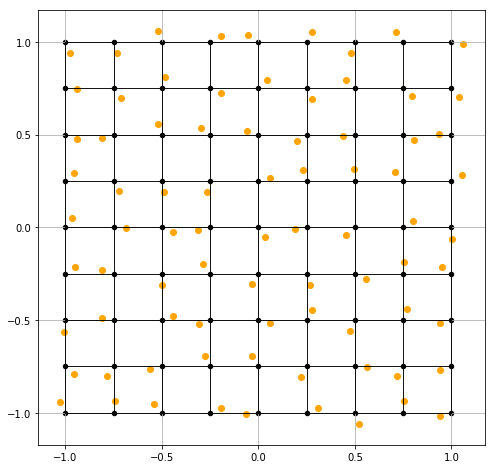

In [7]:
map_size = mid_map_size
n_units = map_size[0] * map_size[1]
r = 0.25
radius = np.array([r * (high - low) / (map_size[0] - 1), r * (high - low) / (map_size[1] - 1)])
angle = np.random.uniform(0.0, 2*np.pi, size=n_units)
X = make_grid(*map_size) + radius * np.dstack((np.cos(angle), np.sin(angle))).squeeze(0)
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c='orange')

dist_fun = rectangular_topology_dist(map_size)
prototypes = make_grid(*map_size)
for i in range(n_units):
    for j in range(n_units):
        if dist_fun(i, j) == 1:
            plt.plot([prototypes[i, 0], prototypes[j, 0]], [prototypes[i, 1], prototypes[j, 1]], 'k-', linewidth=0.7)
plt.scatter(prototypes[:, 0], prototypes[:, 1], s=20, c='k')
plt.grid()

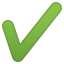

In [8]:
expected_values = np.array([0.125,0.0625,0.03125,0.015625])
somperf_values = np.zeros(len(all_map_sizes))
for i, map_size in enumerate(all_map_sizes):
    r = 0.25
    n_units = map_size[0] * map_size[1]
    radius = np.array([r * (high - low) / (map_size[0] - 1), r * (high - low) / (map_size[1] - 1)])
    angle = np.random.uniform(0.0, 2*np.pi, size=n_units)
    X = make_grid(*map_size) + radius * np.dstack((np.cos(angle), np.sin(angle))).squeeze(0)

    prototypes = make_grid(*map_size)
    somperf_values[i] = quantization_error(som=prototypes, x=X)

test_all_equal(somperf_values, expected_values)

**4. Check that qe decreases with the map size**

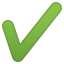

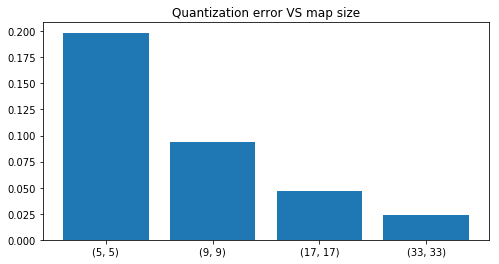

In [9]:
somperf_values = np.zeros(len(all_map_sizes))
for i, map_size in enumerate(all_map_sizes):
    X = make_random(data_size)
    prototypes = make_grid(*map_size)
    somperf_values[i] = quantization_error(som=prototypes, x=X)
    
plt.figure(figsize=(8, 4))
plt.bar(range(len(all_map_sizes)), somperf_values, tick_label=[str(map_size) for map_size in all_map_sizes])
plt.title('Quantization error VS map size')

test_decreasing(somperf_values)

**5. Check that qe increases when adding uniform noise disturbing the map**

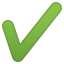

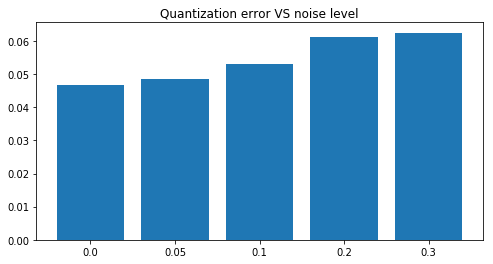

In [10]:
map_size = large_map_size
somperf_values = np.zeros(len(noise_levels))
for i, noise_level in enumerate(noise_levels):
    X = make_random(data_size)
    n_units = map_size[0] * map_size[1]
    prototypes = make_grid(*map_size) + np.random.uniform(0.0, noise_level, size=(n_units, 2))
    somperf_values[i] = quantization_error(som=prototypes, x=X)
    
plt.figure(figsize=(8, 4))
plt.bar(range(len(noise_levels)), somperf_values, tick_label=noise_levels)
plt.title('Quantization error VS noise level')

test_increasing(somperf_values)

**6. Check that qe increases when distorting the map**

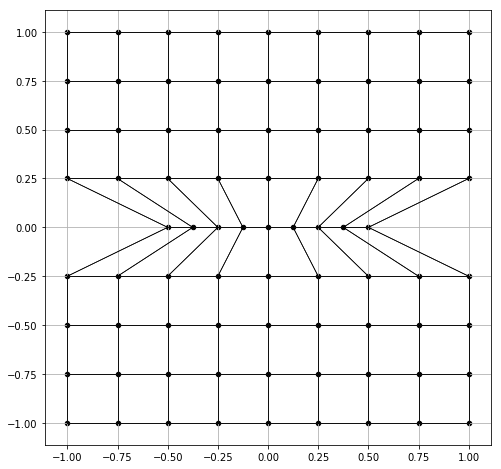

In [11]:
map_size = mid_map_size
n_units = map_size[0] * map_size[1]
dist_fun = rectangular_topology_dist(map_size)
prototypes = make_grid(*map_size)
shrink_factor = 0.5
prototypes[np.arange(n_units) // map_size[1] == map_size[1] // 2] *= np.array([1.0 - shrink_factor, 0.0])

plt.figure(figsize=(8, 8))
for i in range(n_units):
    for j in range(n_units):
        if dist_fun(i, j) == 1:
            plt.plot([prototypes[i, 0], prototypes[j, 0]], [prototypes[i, 1], prototypes[j, 1]], 'k-', linewidth=0.7)
plt.scatter(prototypes[:, 0], prototypes[:, 1], s=20, c='k')
plt.grid()

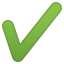

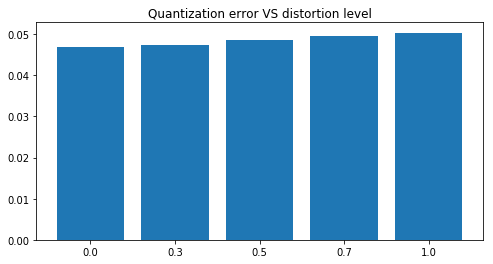

In [12]:
map_size = large_map_size
shrink_factors = [0.0, 0.3, 0.5, 0.7, 1.0]
somperf_values = np.zeros(len(shrink_factors))
for i, shrink_factor in enumerate(shrink_factors):
    X = make_random(data_size)
    n_units = map_size[0] * map_size[1]
    prototypes = make_grid(*map_size)
    prototypes[np.arange(n_units) // map_size[1] == map_size[1] // 2] *= np.array([1.0 - shrink_factor, 0.0])
    somperf_values[i] = quantization_error(som=prototypes, x=X)
    
plt.figure(figsize=(8, 4))
plt.bar(range(len(shrink_factors)), somperf_values, tick_label=[str(shrink_factor) for shrink_factor in shrink_factors])
plt.title('Quantization error VS distortion level')

test_increasing(somperf_values)

### Kruskal-Shepard error

**1. Check that kse decreases with the map size**

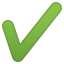

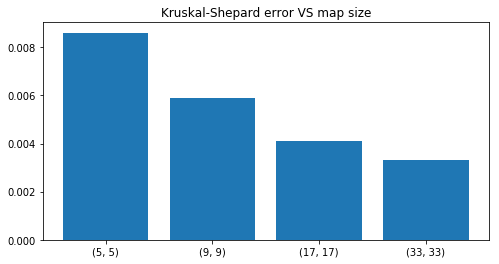

In [13]:
somperf_values = np.zeros(len(all_map_sizes))
for i, map_size in enumerate(all_map_sizes):
    X = make_random(data_size)
    prototypes = make_grid(*map_size)
    dist_fun = rectangular_topology_dist(map_size)
    somperf_values[i] = kruskal_shepard_error(dist_fun=dist_fun, som=prototypes, x=X)
    
plt.figure(figsize=(8, 4))
plt.bar(range(len(all_map_sizes)), somperf_values, tick_label=[str(map_size) for map_size in all_map_sizes])
plt.title('Kruskal-Shepard error VS map size')

test_decreasing(somperf_values)

**2. Check that a random permutation of map units (i.e. removing topology) does increase kse**

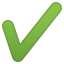

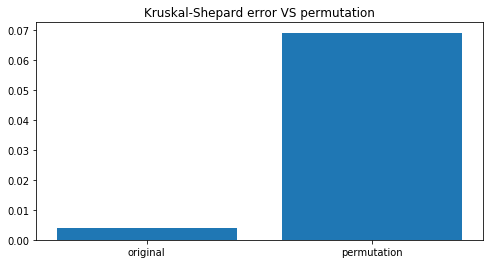

In [14]:
map_size = large_map_size
X = make_random(data_size)
prototypes = make_grid(*map_size)
dist_fun = rectangular_topology_dist(map_size)
somperf_values = np.array([kruskal_shepard_error(dist_fun=dist_fun, som=prototypes, x=X),
                           kruskal_shepard_error(dist_fun=dist_fun, som=np.random.permutation(prototypes), x=X)])

plt.figure(figsize=(8, 4))
plt.bar(range(2), somperf_values, tick_label=['original', 'permutation'])
plt.title('Kruskal-Shepard error VS permutation')

test_increasing(somperf_values)

### Distortion

**1. Check that distortion increases with the neighborhood radius (gaussian neighborhood)**

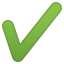

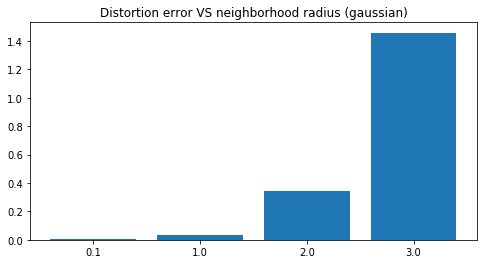

In [15]:
map_size = large_map_size
radiuses = [0.1, 1.0, 2.0, 3.0]
somperf_values = np.zeros(len(radiuses))
X = make_random(data_size)
prototypes = make_grid(*map_size)
dist_fun = rectangular_topology_dist(map_size)
for i, r in enumerate(radiuses):
    neighborhood_fun = gaussian_neighborhood(radius=r)
    somperf_values[i] = distortion(dist_fun=dist_fun, neighborhood_fun=neighborhood_fun, som=prototypes, x=X)

plt.figure(figsize=(8, 4))
plt.bar(range(len(radiuses)), somperf_values, tick_label=radiuses)
plt.title('Distortion error VS neighborhood radius (gaussian)')

test_increasing(somperf_values)

**2. Check that distortion increases with the neighborhood radius (window neighborhood)**

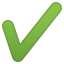

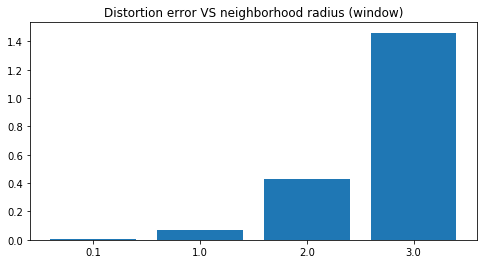

In [16]:
map_size = large_map_size
radiuses = [0.1, 1.0, 2.0, 3.0]
somperf_values = np.zeros(len(radiuses))
X = make_random(data_size)
prototypes = make_grid(*map_size)
dist_fun = rectangular_topology_dist(map_size)
for i, r in enumerate(radiuses):
    neighborhood_fun = window_neighborhood(radius=r)
    somperf_values[i] = distortion(dist_fun=dist_fun, neighborhood_fun=neighborhood_fun, som=prototypes, x=X)

plt.figure(figsize=(8, 4))
plt.bar(range(len(radiuses)), somperf_values, tick_label=radiuses)
plt.title('Distortion error VS neighborhood radius (window)')

test_increasing(somperf_values)

**3. Check that a random permutation of map units (i.e. removing topology) does increase distortion**

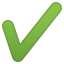

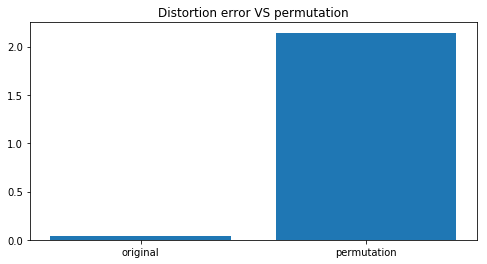

In [17]:
map_size = large_map_size
X = make_random(data_size)
prototypes = make_grid(*map_size)
dist_fun = rectangular_topology_dist(map_size)
neighborhood_fun = gaussian_neighborhood(radius=1.0)
somperf_values = np.array([distortion(dist_fun=dist_fun, neighborhood_fun=neighborhood_fun, som=prototypes, x=X),
                           distortion(dist_fun=dist_fun, neighborhood_fun=neighborhood_fun, som=np.random.permutation(prototypes), x=X)])

plt.figure(figsize=(8, 4))
plt.bar(range(2), somperf_values, tick_label=['original', 'permutation'])
plt.title('Distortion error VS permutation')

test_increasing(somperf_values)

**4. Check that distortion decreases with the map size**

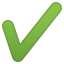

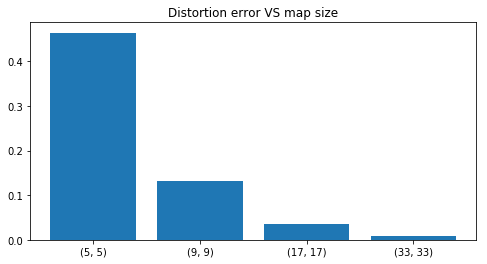

In [18]:
somperf_values = np.zeros(len(all_map_sizes))
X = make_random(data_size)
neighborhood_fun = gaussian_neighborhood(radius=1.0)
for i, map_size in enumerate(all_map_sizes):
    prototypes = make_grid(*map_size)
    dist_fun = rectangular_topology_dist(map_size)
    somperf_values[i] = distortion(dist_fun=dist_fun, neighborhood_fun=neighborhood_fun, som=prototypes, x=X)
    
plt.figure(figsize=(8, 4))
plt.bar(range(len(all_map_sizes)), somperf_values, tick_label=[str(map_size) for map_size in all_map_sizes])
plt.title('Distortion error VS map size')

test_decreasing(somperf_values)

**5. Check that distortion increases when adding uniform noise disturbing the map**

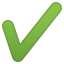

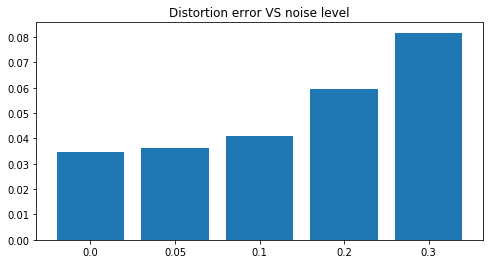

In [19]:
map_size = large_map_size
somperf_values = np.zeros(len(noise_levels))
X = make_random(data_size)
n_units = map_size[0] * map_size[1]
neighborhood_fun = gaussian_neighborhood(radius=1.0)
dist_fun = rectangular_topology_dist(map_size)
for i, noise_level in enumerate(noise_levels):
    prototypes = make_grid(*map_size) + np.random.uniform(0.0, noise_level, size=(n_units, 2))
    somperf_values[i] = distortion(dist_fun=dist_fun, neighborhood_fun=neighborhood_fun, som=prototypes, x=X)
    
plt.figure(figsize=(8, 4))
plt.bar(range(len(noise_levels)), somperf_values, tick_label=noise_levels)
plt.title('Distortion error VS noise level')

test_increasing(somperf_values)

**6. Check that distortion increases when distorting the map**

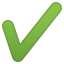

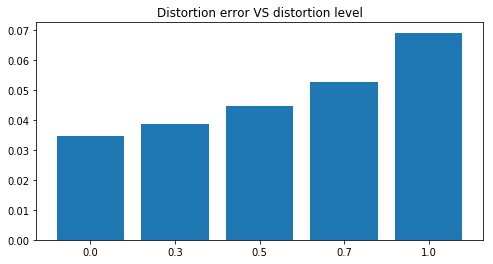

In [20]:
map_size = large_map_size
shrink_factors = [0.0, 0.3, 0.5, 0.7, 1.0]
somperf_values = np.zeros(len(shrink_factors))
neighborhood_fun = gaussian_neighborhood(radius=1.0)
X = make_random(data_size)
n_units = map_size[0] * map_size[1]
dist_fun = rectangular_topology_dist(map_size)
for i, shrink_factor in enumerate(shrink_factors):
    prototypes = make_grid(*map_size)
    prototypes[np.arange(n_units) // map_size[1] == map_size[1] // 2] *= np.array([1.0 - shrink_factor, 0.0])
    somperf_values[i] = distortion(dist_fun=dist_fun, neighborhood_fun=neighborhood_fun, som=prototypes, x=X)
    
plt.figure(figsize=(8, 4))
plt.bar(range(len(shrink_factors)), somperf_values, tick_label=[str(shrink_factor) for shrink_factor in shrink_factors])
plt.title('Distortion error VS distortion level')

test_increasing(somperf_values)

### Topographic error

**1. Check that a regular grid map has 0 topographic error (two best-matching units are always neighbors** 

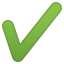

In [21]:
expected_value = 0
somperf_values = np.zeros(len(all_map_sizes))
X = make_random(data_size)
for i, map_size in enumerate(all_map_sizes):
    prototypes = make_grid(*map_size)
    dist_fun = rectangular_topology_dist(map_size)
    somperf_values[i] = topographic_error(dist_fun=dist_fun, som=prototypes, x=X)

test_all_equal(somperf_values, expected_value)

**2. Check that a random permutation of map units (i.e. removing topology) does increase topographic error**

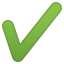

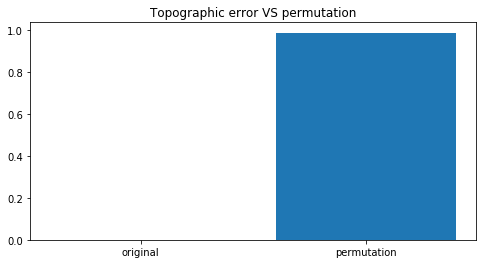

In [22]:
map_size = large_map_size
X = make_random(data_size)
prototypes = make_grid(*map_size)
dist_fun = rectangular_topology_dist(map_size)
somperf_values = np.array([topographic_error(dist_fun=dist_fun, som=prototypes, x=X),
                           topographic_error(dist_fun=dist_fun, som=np.random.permutation(prototypes), x=X)])

plt.figure(figsize=(8, 4))
plt.bar(range(2), somperf_values, tick_label=['original', 'permutation'])
plt.title('Topographic error VS permutation')

test_increasing(somperf_values)

**3. Check that topographic error increases when adding uniform noise disturbing the map**

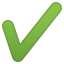

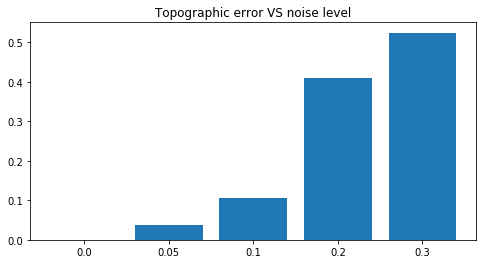

In [23]:
map_size = large_map_size
somperf_values = np.zeros(len(noise_levels))
X = make_random(data_size)
n_units = map_size[0] * map_size[1]
dist_fun = rectangular_topology_dist(map_size)
for i, noise_level in enumerate(noise_levels):
    prototypes = make_grid(*map_size) + np.random.uniform(0.0, noise_level, size=(n_units, 2))
    somperf_values[i] = topographic_error(dist_fun=dist_fun, som=prototypes, x=X)
    
plt.figure(figsize=(8, 4))
plt.bar(range(len(noise_levels)), somperf_values, tick_label=noise_levels)
plt.title('Topographic error VS noise level')

test_increasing(somperf_values)

### Combined error

**1. Check value when samples and prototypes are identical for every map_size**

Expected values: $\frac{2}{\text{map size} - 1} = [0.5, 0.25, 0.125, 0.0625]$

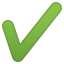

In [24]:
expected_values = np.array([0.5, 0.25, 0.125, 0.0625])
somperf_values = np.zeros(len(all_map_sizes))
for i, map_size in enumerate(all_map_sizes):
    X = make_grid(*map_size)
    prototypes = make_grid(*map_size)
    dist_fun = rectangular_topology_dist(map_size)
    somperf_values[i] = combined_error(dist_fun=dist_fun, som=prototypes, x=X)

test_all_equal(somperf_values, expected_values)

**2. Check that a random permutation of map units (i.e. removing topology) does increase combined error**

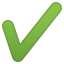

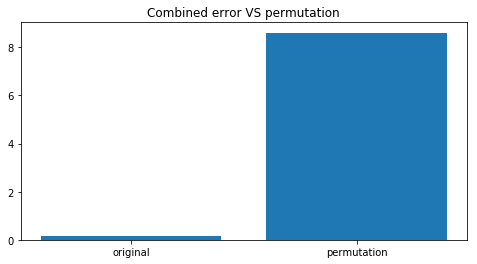

In [25]:
map_size = large_map_size
X = make_random(data_size)
prototypes = make_grid(*map_size)
dist_fun = rectangular_topology_dist(map_size)
somperf_values = np.array([combined_error(dist_fun=dist_fun, som=prototypes, x=X),
                           combined_error(dist_fun=dist_fun, som=np.random.permutation(prototypes), x=X)])

plt.figure(figsize=(8, 4))
plt.bar(range(2), somperf_values, tick_label=['original', 'permutation'])
plt.title('Combined error VS permutation')

test_increasing(somperf_values)

**3. Check that combined error increases when adding uniform noise disturbing the map**

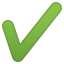

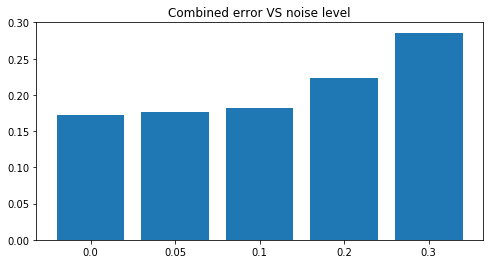

In [26]:
map_size = large_map_size
somperf_values = np.zeros(len(noise_levels))
X = make_random(data_size)
n_units = map_size[0] * map_size[1]
dist_fun = rectangular_topology_dist(map_size)
for i, noise_level in enumerate(noise_levels):
    prototypes = make_grid(*map_size) + np.random.uniform(0.0, noise_level, size=(n_units, 2))
    somperf_values[i] = combined_error(dist_fun=dist_fun, som=prototypes, x=X)
    
plt.figure(figsize=(8, 4))
plt.bar(range(len(noise_levels)), somperf_values, tick_label=noise_levels)
plt.title('Combined error VS noise level')

test_increasing(somperf_values)

**4. Check that combined error achieves to combine quantization and topographic errors**

We perform an experiment similar to Fig. 1 in Kaski & Lagus (1996). "Comparing Self-Organizing Maps". This experiment compares one-dimensional SOMs with different shapes:

* (1) a complex sine-like shape
* (2) a straight line going through the center of the data distribution
* (3) a straight line shift to the side of the data distribution

Intuitively, the most reasonable result to approximate this data manifold would be the straight line (2). We expect following results:

* (1) and (2) have the lowest quantization errors
* (2) and (3) have the lowest topographic errors
* only (2) has the lowest combined error

In [27]:
def make_stripe(size, seed=random_seed):
    return make_random(data_size, low=[-0.1, -1.0], high=[0.1, 1.0], seed=seed)
    
def make_snake(size, seed=random_seed):
    y1 = np.linspace(-0.95, 0.95, size)
    x1 = 0.08 * np.sin(6 * np.pi * y1)
    return np.dstack((x1, y1)).squeeze(0)

def make_line(size, seed=random_seed):
    x1 = np.zeros(size)
    y1 = np.linspace(-0.95, 0.95, size)
    return np.dstack((x1, y1)).squeeze(0)

def make_line_2(size, seed=random_seed):
    x1 = 0.08*np.ones(size)
    y1 = np.linspace(-0.95, 0.95, size)
    return np.dstack((x1, y1)).squeeze(0)

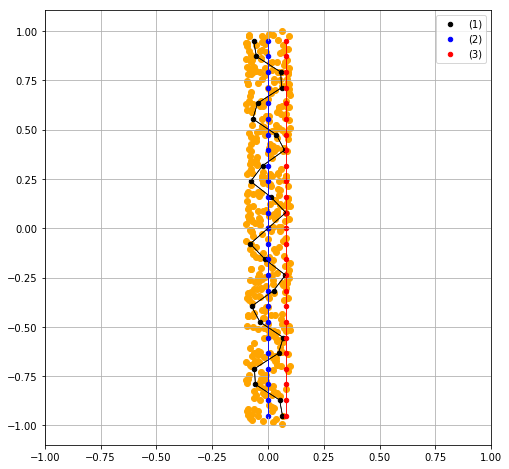

In [28]:
n_units = 25

X_stripe = make_stripe(data_size)
dist_fun = rectangular_topology_dist((n_units, 1))
sine = make_snake(n_units)
line = make_line(n_units)
line2 = make_line_2(n_units)

plt.figure(figsize=(8, 8))
plt.scatter(X_stripe[:, 0], X_stripe[:, 1], c='orange')

for i in range(n_units):
    for j in range(n_units):
        if dist_fun(i, j) == 1:
            plt.plot([sine[i, 0], sine[j, 0]], [sine[i, 1], sine[j, 1]], 'k-', linewidth=0.7)
            plt.plot([line[i, 0], line[j, 0]], [line[i, 1], line[j, 1]], 'b-', linewidth=0.7)
            plt.plot([line2[i, 0], line2[j, 0]], [line2[i, 1], line2[j, 1]], 'r-', linewidth=0.7)
plt.scatter(sine[:, 0], sine[:, 1], s=20, c='k', label='(1)')
plt.scatter(line[:, 0], line2[:, 1], s=20, c='b', label='(2)')
plt.scatter(line2[:, 0], line2[:, 1], s=20, c='r', label='(3)')
plt.grid()
plt.xlim([-1.0, 1.0])
plt.legend();

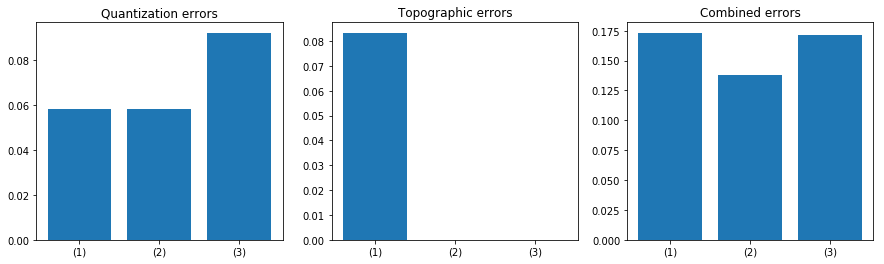

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

qes = [quantization_error(som=sine, x=X_stripe),
       quantization_error(som=line, x=X_stripe),
       quantization_error(som=line2, x=X_stripe)]
tes = [topographic_error(dist_fun=dist_fun, som=sine, x=X_stripe),
       topographic_error(dist_fun=dist_fun, som=line, x=X_stripe),
       topographic_error(dist_fun=dist_fun, som=line2, x=X_stripe)]
ces = [combined_error(dist_fun=dist_fun, som=sine, x=X_stripe),
       combined_error(dist_fun=dist_fun, som=line, x=X_stripe),
       combined_error(dist_fun=dist_fun, som=line2, x=X_stripe)]

ax[0].bar([0, 1, 2], qes, tick_label=['(1)', '(2)', '(3)']);
ax[0].set_title('Quantization errors')
ax[1].bar([0, 1, 2], tes, tick_label=['(1)', '(2)', '(3)']);
ax[1].set_title('Topographic errors')
ax[2].bar([0, 1, 2], ces, tick_label=['(1)', '(2)', '(3)']);
ax[2].set_title('Combined errors');

Our intuition and the result of Kaski and Lagus are confirmed:

* Quantization error cannot distinguish between solutions (1) and (2) as it produces exactly the same values
* Topographic error is 0 for both solutions (2) and (3)
* Combined error is clearly lower for solution (2), thus combined error is the only measure able to recover the right result.

![OK](rc/check.png)

### Topographic product

Topographic product depends only on the map prototypes and not on the data distribution. Its particular ability is to show if the map is too _small_ or too _large_ to fit the data distribution.

* If $tp < 0$, the map is too small
* If $tp > 0$, the map is too large
* The best value is the smallest in absolute value

To assess if the SOMperf implementation is correct, we reproduce an experiment from the original paper: Bauer, Pawelzik & Geisel, T. (1992), "A Topographic Product for the Optimization of Self-Organizing Feature Maps".

It consists in generating a 2D data distribution on a rectangular support, uniform on one dimension and gaussian on the other dimension, and then fitting rectangular self-organizing maps with different aspect ratios but the same number of units.

The idea is that the narrower maps ($256  \times 1$, $128 \times 2$ and $64 \times 4$) will be too small, producing artificial folds and produce $tp < 0$, while on the other side, the wider maps also have the wrong aspect ratio and will artificially push units closer on one dimension, thus producing $tp > 0$.

As in the paper, we run 8 map trainings and 

map size | number of units | aspect ratio | TP
---------|-----------------|--------------|----
$256 \times 1$ | 256 | 256 | $-0.07861 \pm 0.00983$
$128 \times 2$ | 256 | 64 | $-0.04178 \pm 0.01427$
$64 \times 4$ | 256 | 16 | $-0.01331 \pm 0.00732$
$43 \times 6$ | 258 | 7.17 | $\mathbf{0.00101} \pm 0.00010$
$32 \times 8$ | 256 | 4 | $0.00231 \pm 0.00008$
$26 \times 10$ | 260 | 2.6 | $0.00395 \pm 0.00028$
$21 \times 12$ | 252 | 1.75 | $0.00619 \pm 0.00053$
$16 \times 16$ | 256 | 1 | $0.01188 \pm 0.00256$

The map with the lowest topographic product is the $43 \times 6$ map, which has the right rectangular aspect ratio, exactly as in the paper's experiment.

![OK](rc/check.png)

In [30]:
np.random.seed(random_seed)
size = 5000
sigma = 0.06
x = np.random.normal(0.5, sigma, size)
y = np.random.uniform(0.0, 1.0, size)
X = np.c_[x, y]

/usr/local/lib/python3.5/dist-packages/minisom.py:127: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


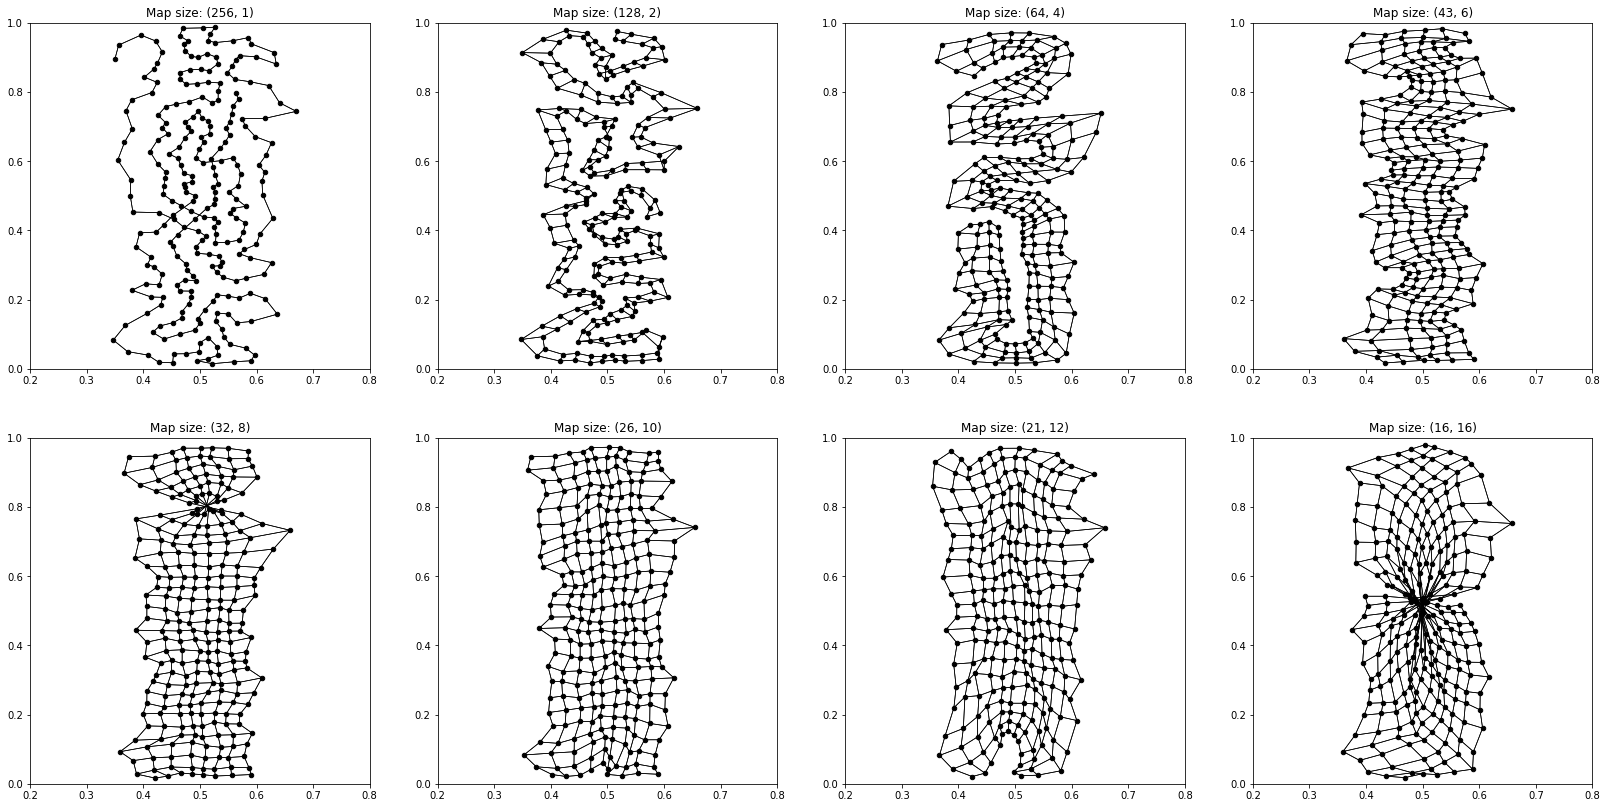

In [31]:
from minisom import MiniSom

map_sizes = [
    (256, 1),
    (128, 2),
    (64, 4),
    (43, 6),
    (32, 8),
    (26, 10),
    (21, 12),
    (16, 16)
]

n_iter = 10 * size  # 10 epochs
n_runs = 8

tps = np.zeros((len(map_sizes), n_runs))

fig, ax = plt.subplots(2, 4, figsize=(28, 14))

for idx,map_size in enumerate(map_sizes):
    n_units = map_size[0] * map_size[1]
    dist_fun = rectangular_topology_dist(map_size)

    som = MiniSom(map_size[0], map_size[1], X.shape[-1], sigma=1.0, learning_rate=1.0, random_seed=random_seed)
        
    best_tp = 1.0
    for run in range(n_runs):
        som.random_weights_init(X)
        som.train_batch(X, n_iter)
        prototypes = som.get_weights().reshape(-1, X.shape[-1])
        tps[idx, run] = topographic_product(dist_fun, prototypes)
        if tps[idx, run] < best_tp:
            best_tp = tps[idx, run]
            best_prototypes = prototypes

    # Visualize map prototypes
    for i in range(n_units):
        for j in range(n_units):
            if dist_fun(i, j) == 1:
                ax[idx//4, idx%4].plot([best_prototypes[i, 0], best_prototypes[j, 0]], [best_prototypes[i, 1], best_prototypes[j, 1]], 'k-', linewidth=0.7)
    ax[idx//4, idx%4].scatter(best_prototypes[:, 0], best_prototypes[:, 1], s=20, c='k')
    ax[idx//4, idx%4].set_title('Map size: {}'.format(map_size))
    ax[idx//4, idx%4].set_xlim([0.2, 0.8])
    ax[idx//4, idx%4].set_ylim([0.0, 1.0])

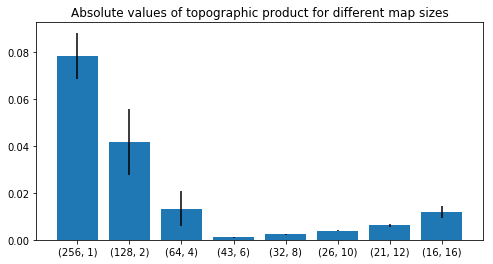

In [32]:
plt.figure(figsize=(8, 4))
plt.bar(range(len(map_sizes)), np.abs(tps.mean(axis=1)), yerr=tps.std(axis=1), tick_label=[str(s) for s in map_sizes])
plt.title('Absolute values of topographic product for different map sizes');

### Neighborhood preservation

**1. Check neighborhood preservation against manual computation**

We manually compute neighborhood preservation on 2 tiny test cases and check equality with SOMperf. The test cases introduce ties in both input and output pairwise distances.

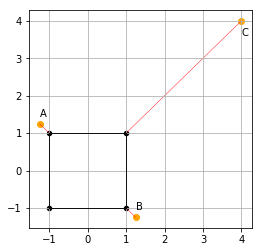

In [33]:
# Manual setting 1
map_size = (2, 2)
n_units = map_size[0] * map_size[1]
dist_fun = rectangular_topology_dist(map_size)
prototypes = make_grid(*map_size)
X = np.array([[-1.25, 1.25],
              [1.25, -1.25],
              [4.0, 4.0]])
projections = np.array([[-1.0, 1.0],
                        [1.0, -1.0],
                        [1.0, 1.0]])

plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], c='orange')
plt.text(X[0, 0], X[0, 1] + 0.2, 'A')
plt.text(X[1, 0], X[1, 1] + 0.2, 'B')
plt.text(X[2, 0], X[2, 1] - 0.4, 'C')
for i in range(X.shape[0]):
    plt.arrow(X[i, 0], X[i, 1], projections[i, 0] - X[i, 0], projections[i, 1] - X[i, 1], color='r', linewidth=0.2)

for i in range(n_units):
    for j in range(n_units):
        if dist_fun(i, j) == 1:
            plt.plot([prototypes[i, 0], prototypes[j, 0]], [prototypes[i, 1], prototypes[j, 1]], 'k-', linewidth=0.7)
plt.scatter(prototypes[:, 0], prototypes[:, 1], s=20, c='k')
plt.grid();

Using notations from Venna & Kaski (2001), "Neighborhood preservation in nonlinear projection methods: An experimental study.", we have:

$N = 3, k = 1$

$V_1(A) = \{B\}$ (i.e. points that are 1-nearest neighbors of A before projection but not after projection)

$V_1(B) = \{A\}$

$V_1(C) = \emptyset$, weighted by $2/2 = 1$ because of ties before and after projection

$\hat{r}_1(A, B) = 2$,
$\hat{r}_1(B, A) = 2$

Expected value: $NP_1 = 1 - \frac{2}{3 \times 2}\left[ (2-1) + (2-1) \right] = 1 - \frac{1}{3} \times 2 = \frac{1}{3} = 0.333333333$

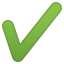

In [34]:
expected_value = 0.333333333
somperf_value = neighborhood_preservation(k=1, som=prototypes, x=X)

test_equal(somperf_value, expected_value)

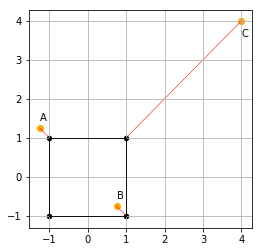

In [35]:
# Manual setting 2
map_size = (2, 2)
n_units = map_size[0] * map_size[1]
dist_fun = rectangular_topology_dist(map_size)
prototypes = make_grid(*map_size)
X = np.array([[-1.25, 1.25],
              [0.75, -0.75],
              [4.0, 4.0]])
projections = np.array([[-1.0, 1.0],
                        [1.0, -1.0],
                        [1.0, 1.0]])

plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], c='orange')
plt.text(X[0, 0], X[0, 1] + 0.2, 'A')
plt.text(X[1, 0], X[1, 1] + 0.2, 'B')
plt.text(X[2, 0], X[2, 1] - 0.4, 'C')
for i in range(X.shape[0]):
    plt.arrow(X[i, 0], X[i, 1], projections[i, 0] - X[i, 0], projections[i, 1] - X[i, 1], color='r', linewidth=0.25)

for i in range(n_units):
    for j in range(n_units):
        if dist_fun(i, j) == 1:
            plt.plot([prototypes[i, 0], prototypes[j, 0]], [prototypes[i, 1], prototypes[j, 1]], 'k-', linewidth=0.7)
plt.scatter(prototypes[:, 0], prototypes[:, 1], s=20, c='k')
plt.grid();

$V_1(A) = \{B\}$ (i.e. points that are 1-nearest neighbors of A before projection but not after projection)

$V_1(B) = \{A\}$

$V_1(C) = \emptyset$, weighted by $2/1 = 2$ because of ties after projection

$\hat{r}_1(A, B) = 2$,
$\hat{r}_1(B, A) = 2$

Expected value: $NP_1 = 1 - \frac{2}{3 \times 2}\left[ (2-1) + (2-1) \right] = 1 - \frac{1}{3} \times 2 = \frac{1}{3} = 0.333333333$

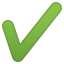

In [36]:
expected_value = 0.333333333
somperf_value = neighborhood_preservation(k=1, som=prototypes, x=X)

test_equal(somperf_value, expected_value)

**2. Check that neighborhood preservation increases with the map size**

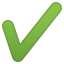

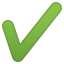

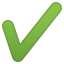

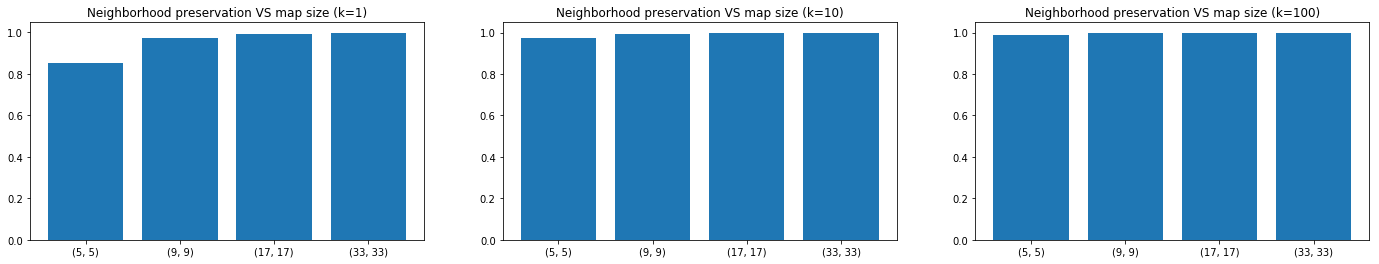

In [37]:
X = make_random(data_size)
ks = [1, 10, 100]
somperf_values = np.zeros((len(ks), len(all_map_sizes)))
for i, map_size in enumerate(all_map_sizes):
    prototypes = make_grid(*map_size)
    for j,k in enumerate(ks):
        somperf_values[j, i] = neighborhood_preservation(k, som=prototypes, x=X)

fig, ax = plt.subplots(1, len(ks), figsize=(24, 4))
for j,k in enumerate(ks):
    ax[j].bar(range(len(all_map_sizes)), somperf_values[j], tick_label=[str(map_size) for map_size in all_map_sizes])
    ax[j].set_title('Neighborhood preservation VS map size (k={})'.format(k))

for j in range(len(ks)):
    test_increasing(somperf_values[j])

### Trustworthiness

**1. Check trustworthiness against manual computation**

We manually compute trustworthiness on a tiny test case and check equality with SOMperf. The test case introduces ties in both input and output pairwise distances.

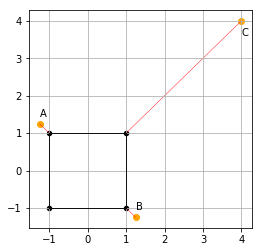

In [38]:
# Manual setting 1
map_size = (2, 2)
n_units = map_size[0] * map_size[1]
dist_fun = rectangular_topology_dist(map_size)
prototypes = make_grid(*map_size)
X = np.array([[-1.25, 1.25],
              [1.25, -1.25],
              [4.0, 4.0]])
projections = np.array([[-1.0, 1.0],
                        [1.0, -1.0],
                        [1.0, 1.0]])

plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], c='orange')
plt.text(X[0, 0], X[0, 1] + 0.2, 'A')
plt.text(X[1, 0], X[1, 1] + 0.2, 'B')
plt.text(X[2, 0], X[2, 1] - 0.4, 'C')
for i in range(X.shape[0]):
    plt.arrow(X[i, 0], X[i, 1], projections[i, 0] - X[i, 0], projections[i, 1] - X[i, 1], color='r', linewidth=0.2)

for i in range(n_units):
    for j in range(n_units):
        if dist_fun(i, j) == 1:
            plt.plot([prototypes[i, 0], prototypes[j, 0]], [prototypes[i, 1], prototypes[j, 1]], 'k-', linewidth=0.7)
plt.scatter(prototypes[:, 0], prototypes[:, 1], s=20, c='k')
plt.grid();

Using notations from Venna & Kaski (2001), "Neighborhood preservation in nonlinear projection methods: An experimental study.", we have:

$N = 3, k = 1$

$U_1(A) = \{C\}$ (i.e. points that are 1-nearest neighbors of A after projection but not before projection)

$U_1(B) = \{C\}$

$U_1(C) = \emptyset$, weighted by $2/2 = 1$ because of ties before and after projection

$r_1(A, C) = 2$,
$r_1(B, C) = 2$

Expected value: $NP_1 = 1 - \frac{2}{3 \times 2}\left[ (2-1) + (2-1) \right] = 1 - \frac{1}{3} \times 2 = \frac{1}{3} = 0.333333333$

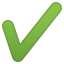

In [39]:
expected_value = 0.333333333
somperf_value = trustworthiness(k=1, som=prototypes, x=X)

test_equal(somperf_value, expected_value)

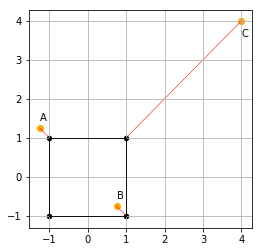

In [40]:
# Manual setting 2
map_size = (2, 2)
n_units = map_size[0] * map_size[1]
dist_fun = rectangular_topology_dist(map_size)
prototypes = make_grid(*map_size)
X = np.array([[-1.25, 1.25],
              [0.75, -0.75],
              [4.0, 4.0]])
projections = np.array([[-1.0, 1.0],
                        [1.0, -1.0],
                        [1.0, 1.0]])

plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], c='orange')
plt.text(X[0, 0], X[0, 1] + 0.2, 'A')
plt.text(X[1, 0], X[1, 1] + 0.2, 'B')
plt.text(X[2, 0], X[2, 1] - 0.4, 'C')
for i in range(X.shape[0]):
    plt.arrow(X[i, 0], X[i, 1], projections[i, 0] - X[i, 0], projections[i, 1] - X[i, 1], color='r', linewidth=0.25)

for i in range(n_units):
    for j in range(n_units):
        if dist_fun(i, j) == 1:
            plt.plot([prototypes[i, 0], prototypes[j, 0]], [prototypes[i, 1], prototypes[j, 1]], 'k-', linewidth=0.7)
plt.scatter(prototypes[:, 0], prototypes[:, 1], s=20, c='k')
plt.grid();

$U_1(A) = \{C\}$ (i.e. points that are 1-nearest neighbors of A after projection but not before projection)

$U_1(B) = \{C\}$

$U_1(C) = \{A\}$, weighted by $1/2$ because of ties after projection

$r_1(A, C) = 2$,
$r_1(B, C) = 2$,
$r_1(C, A) = 2$, weighted by $1/2$ because of ties after projection

Expected value: $NP_1 = 1 - \frac{2}{3 \times 2}\left[ (2-1) + (2-1) + \frac{1}{2}(2-1)\right] = 1 - \frac{1}{3} \times \frac{5}{2} = \frac{1}{6} = 0.166666667$

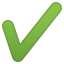

In [41]:
expected_value = 0.166666667
somperf_value = trustworthiness(k=1, som=prototypes, x=X)

test_equal(somperf_value, expected_value)

**2. Check that trustworthiness increases with the map size**

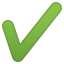

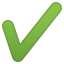

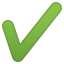

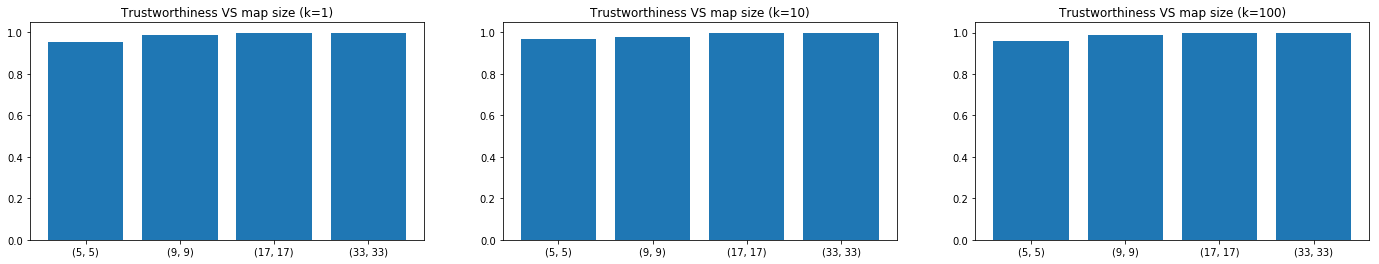

In [42]:
X = make_random(data_size)
ks = [1, 10, 100]
somperf_values = np.zeros((len(ks), len(all_map_sizes)))
for i, map_size in enumerate(all_map_sizes):
    prototypes = make_grid(*map_size)
    for j,k in enumerate(ks):
        somperf_values[j, i] = trustworthiness(k, som=prototypes, x=X)

fig, ax = plt.subplots(1, len(ks), figsize=(24, 4))
for j,k in enumerate(ks):
    ax[j].bar(range(len(all_map_sizes)), somperf_values[j], tick_label=[str(map_size) for map_size in all_map_sizes])
    ax[j].set_title('Trustworthiness VS map size (k={})'.format(k))

for j in range(len(ks)):
    test_increasing(somperf_values[j])

## External indices

We use following hand-crafted map with 3 classes (red=0, yellow=1 and blue=2) for the tests:

<img src="rc/som-classes.svg" />

Numerical values are tested for equality up to 9 digits.



In [43]:
# Pre-defined map
map_size = (5, 5)
dist_fun = rectangular_topology_dist(map_size=map_size)
y_true = np.array([0, 0, 0, 0, 0, 1, 0, 2, 0,
                   0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
                   0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2,
                   0, 1, 1, 1, 2, 2, 2, 2,
                   2, 1, 1, 2, 2, 2, 2, 2])
y_pred = np.array([0, 0, 0, 1, 1, 1, 2, 3, 4,
                   5, 5, 5, 6, 6, 6, 7, 8, 9, 9,
                   10, 10, 11, 11, 12, 12, 12, 13, 13, 13, 14,
                   15, 17, 17, 18, 18, 19, 19, 19,
                   20, 21, 22, 22, 22, 23, 24, 24])

### Class scatter index (CSI)

There are respectively 2, 1, and 3 groups in each class.

![groups 0](rc/som-classes-csi-1.svg) ![groups 1](rc/som-classes-csi-3.svg) ![groups 2](rc/som-classes-csi-2.svg)

Expected value: $\frac{2 + 1 + 3}{6} = 2$

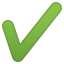

In [44]:
expected_value = 2.0
somperf_value  = class_scatter_index(dist_fun, y_true, y_pred)

test_equal(somperf_value, expected_value)

### Entropy

Expected value: $\sum_k -\log(\text{relative frequencies of majority class}) = 3.701301974$ 

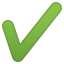

In [45]:
freqs = np.array([1, 2/3, 1, 1, 1, 1, 2/3, 1, 1, 1/2, 1, 1/2, 1, 2/3, 1, 1, 1, 1/2, 1, 1, 1, 2/3, 1, 1])
expected_value = np.sum(-np.log(freqs))
somperf_value  = entropy(y_true, y_pred)

test_equal(somperf_value, expected_value)

### Normalized Minor Class Occurrence

Expected value: $\frac{7}{46} = 0.152173913$

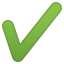

In [46]:
expected_value = 0.152173913
somperf_value  = normalized_minor_class_occurrence(y_true, y_pred)

test_equal(somperf_value, expected_value)

### Purity

Expected value: $\frac{39}{46} = 0.847826087$

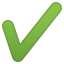

In [47]:
expected_value = 0.847826087
somperf_value  = purity(y_true, y_pred)

test_equal(somperf_value, expected_value)

### Unsupervised clustering accuracy

To compute unsupervised clustering accuracy, the number of clusters needs to be equal to the number of target classes. Thus, we consider the following _super-clusters_ on top of the map, that could have been obtained by clustering the prototypes into 3 clusters using for instance $k$-means or hierarchical clustering, and finding the optimal assignment between clusters and class labels.

<img src="rc/som-classes-superclusters.svg" />

Then we compute a standard supervised classification accuracy on these clusters.

Expected value: $\frac{38}{46} = 0.826086957$

In [48]:
# the labeling has no importance since clustering accuracy finds the best matching between cluster labels and true labels
y_superclusters = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0,
                            0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
                            0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1,
                            0, 2, 2, 1, 1, 1, 1, 1,
                            1, 2, 2, 2, 2, 1, 1, 1])

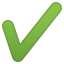

In [49]:
expected_value = 0.826086957
somperf_value  = clustering_accuracy(y_true, y_superclusters)

test_equal(somperf_value, expected_value)